In [1]:
import os

In [2]:
import datasets

ModuleNotFoundError: No module named 'datasets'

In [3]:
local_dir = '/cwStorage/nodecw_group/jijh/hest_1k'

In [ ]:
help(datasets.load_dataset)

In [5]:
import datasets

# 数据集脚本的本地路径
dataset_script_path = '/cwStorage/nodecw_group/jijh/hest_1k/hest.py'

# 本地数据集路径
data_dir = '/cwStorage/nodecw_group/jijh/hest_1k'

# 加载本地数据集脚本
dataset = datasets.load_dataset(
    dataset_script_path,
    data_dir=data_dir,
    name="custom_config"  # 使用自定义配置名称
)

# 示例：查看数据集的训练集
print(dataset['train'])

In [254]:
dataset['train'][]

# 我自己的方法

In [2]:
os.chdir("/home1/jijh/diffusion_project/ADiffusion")

In [3]:
os.getcwd()

'/public/home/jijh/diffusion_project/ADiffusion'

In [4]:

import importlib
from src.pipeline.hest_loading import HESTDataset



In [5]:
# 假设数据路径
data_dir = "/cwStorage/nodecw_group/jijh/hest_1k"

# 初始化数据集管理
dataset = HESTDataset(data_dir=data_dir)

In [6]:
dataset.meta_df

,dataset_title,id,image_filename,organ,disease_state,oncotree_code,species,patient,st_technology,data_publication_date,...,treatment_comment,pixel_size_um_embedded,pixel_size_um_estimated,magnification,fullres_px_width,fullres_px_height,tissue,disease_comment,subseries,hest_version_added
0,Fresh Frozen Mouse Brain Hemisphere with 5K Mo...,TENX159,TENX159.tif,Brain,Healthy,NaN,Mus musculus,NaN,Xenium,7/31/24,...,NaN,0.273768,0.274027,40x,17051,24689,Brain,NaN,NaN,v1_1_0
1,FFPE Human Skin Primary Dermal Melanoma with 5...,TENX158,TENX158.tif,Skin,Cancer,SKCM,Homo sapiens,NaN,Xenium,7/31/24,...,NaN,0.273777,0.273754,40x,18669,35787,Skin,Primary Dermal Melanoma,NaN,v1_1_0
2,FFPE Human Prostate Adenocarcinoma with 5K Hum...,TENX157,TENX157.tif,Prostate,Cancer,PRAD,Homo sapiens,NaN,Xenium,7/31/24,...,NaN,0.273772,0.273741,40x,25002,49976,Prostate,NaN,NaN,v1_1_0
3,Characterization of immune cell populations in...,TENX156,TENX156.tif,Bowel,Cancer,COAD,Homo sapiens,Patient 1,Visium HD,7/11/24,...,NaN,0.264583,0.273802,40x,71106,58791,Colon,Stage II-A,"Visium HD, Sample P1 CRC",v1_1_0
4,Characterization of immune cell populations in...,TENX155,TENX155.tif,Bowel,Cancer,COAD,Homo sapiens,Patient 1,Visium HD,7/11/24,...,NaN,0.264583,0.273874,40x,75250,48740,Colon,NaN,"Visium HD, Sample P2 CRC",v1_1_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224,spatialLIBD,MISC5,MISC5.tif,Brain,Healthy,NaN,Homo sapiens,,Visium,NaN,...,NaN,NaN,0.727113,20x,13332,13332,dorsolateral prefrontal cortex,NaN,151672,v1_0_0
1225,spatialLIBD,MISC4,MISC4.tif,Brain,Healthy,NaN,Homo sapiens,,Visium,NaN,...,NaN,NaN,0.726109,20x,13332,13332,dorsolateral prefrontal cortex,NaN,151673,v1_0_0
1226,spatialLIBD,MISC3,MISC3.tif,Brain,Healthy,NaN,Homo sapiens,,Visium,NaN,...,NaN,NaN,0.725124,20x,13332,13332,dorsolateral prefrontal cortex,NaN,151674,v1_0_0
1227,spatialLIBD,MISC2,MISC2.tif,Brain,Healthy,NaN,Homo sapiens,,Visium,NaN,...,NaN,NaN,0.726109,20x,13332,13332,dorsolateral prefrontal cortex,NaN,151675,v1_0_0


In [7]:
dataset.meta_df['species'].value_counts()

species
Homo sapiens    649
Mus musculus    580
Name: count, dtype: int64

# 数据预览

In [12]:
def get_counts_per_spot_robust(adata, chunk_size=2000):
    """
    稳健地计算每个 spot/cell 的 UMI counts 总和，专门用于处理 AnnData 的 backed mode。
    这种方法通过分块处理来避免将整个矩阵加载到内存中，并可以处理
    不支持 .sum() 方法的 h5py Dataset 代理对象。

    参数:
      adata (anndata.AnnData): 以 backed mode 加载的 AnnData 对象。
      chunk_size (int): 一次处理的 spot/cell 数量。

    返回:
      np.ndarray: 一个包含每个 spot/cell 的 UMI counts 总和的 NumPy 数组。
    """
    sums = []
    # 遍历所有观测值（spots/cells），按 chunk_size 分块
    for i in range(0, adata.n_obs, chunk_size):
        # 定义当前块的切片
        chunk_slice = slice(i, min(i + chunk_size, adata.n_obs))
        
        # 从磁盘读取当前块的数据。这将返回一个 NumPy 数组或 SciPy 稀疏矩阵。
        chunk_data = adata.X[chunk_slice, :]
        
        # 对内存中的块计算行和。np.sum 适用于 dense 和 sparse 矩阵。
        chunk_sums = np.array(chunk_data.sum(axis=1)).flatten()
        sums.append(chunk_sums)
        
    # 将所有块的计算结果连接成一个单独的数组
    return np.concatenate(sums)


In [ ]:
# 获取所有样本的 HESTSample 对象列表
# 此时，AnnData 和 WSI 数据尚未加载到内存中
print("\n正在获取所有样本对象...")
all_samples = dataset.get_samples()
print(f"成功获取 {len(all_samples)} 个样本对象。")


正在获取所有样本对象...
成功获取 1229 个样本对象。


In [13]:
from tqdm.auto import tqdm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# --- 2. 懒加载并收集统计数据 ---
# 创建列表来存储所有样本的统计信息
per_sample_stats = []
all_counts_per_spot = []

print("\n开始遍历所有样本，懒加载 AnnData 并收集统计数据...")
# 使用 tqdm 创建一个进度条
for sample in tqdm(all_samples, desc="处理样本"):
    try:
        # 懒加载 AnnData 对象
        adata = sample.load_st_data(lazy=True)

        if adata is None:
            continue

        # a) 统计基因数量 (n_vars)
        n_genes = adata.n_vars

        # b) 使用我们新的稳健方法来统计每个 spot 的 UMI counts
        # ==================== 这是修改的关键部分 ====================
        counts_per_spot = get_counts_per_spot_robust(adata)
        # ==========================================================
        
        # 存储单样本的统计信息
        per_sample_stats.append({
            'sample_id': sample.sample_id,
            'n_genes': n_genes,
            'n_spots': adata.n_obs,
            'total_counts': counts_per_spot.sum()
        })
        
        # 将当前样本的所有 spot 的 counts 添加到总列表中
        all_counts_per_spot.extend(counts_per_spot)

    except Exception as e:
        # 这个捕获现在应该很少被触发，除非文件损坏或格式完全错误
        print(f"处理样本 {sample.sample_id} 时发生未预料的错误: {e}")

print("\n数据收集完成。")
print("注意：已使用内存高效的分块方法来处理所有类型的H5AD文件。")


开始遍历所有样本，懒加载 AnnData 并收集统计数据...


处理样本:   0%|          | 0/1229 [00:00<?, ?it/s]

/public/home/jijh/micromamba/envs/gpu_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/public/home/jijh/micromamba/envs/gpu_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/public/home/jijh/micromamba/envs/gpu_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/public/home/jijh/micromamba/envs/gpu_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/public/home/jijh/micromamba/envs/gpu_env/lib/python3.12/sit


数据收集完成。
注意：已使用内存高效的分块方法来处理所有类型的H5AD文件。


In [15]:
# 将单样本统计信息转换为 DataFrame
stats_df = pd.DataFrame(per_sample_stats)

print("\n--- 每个样本的统计数据概览 ---")
print(stats_df.head())
print("\n--- 基因数量和总 Counts 的描述性统计 (按样本) ---")
print(stats_df[['n_genes', 'total_counts']].describe())


--- 每个样本的统计数据概览 ---
  sample_id  n_genes  n_spots total_counts
0   TENX159    13780     3429    188540362
1   TENX158    10017     2179     74011892
2   TENX157    10006     4427     59727355
3   TENX156    18085     2179    1708639.0
4   TENX155    18085     2281    4336778.0

--- 基因数量和总 Counts 的描述性统计 (按样本) ---
            n_genes
count   1229.000000
mean   22632.218877
std    10589.161338
min      538.000000
25%    15670.000000
50%    19396.000000
75%    32285.000000
max    68886.000000



Generating visualization charts...


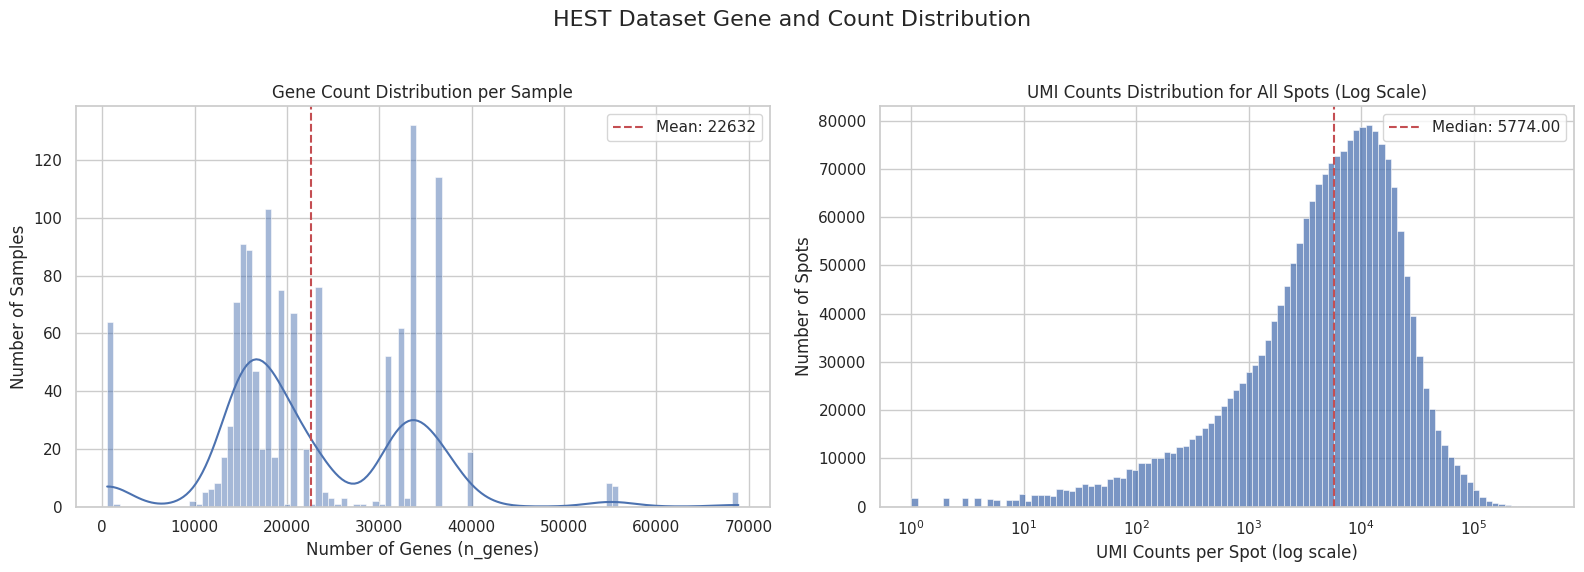

In [20]:
# --- 4. Visualization ---
print("\nGenerating visualization charts...")
sns.set_theme(style="whitegrid")

# Create a 1x2 subplot layout
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('HEST Dataset Gene and Count Distribution', fontsize=16)

# Plot 1: Gene count distribution per sample
sns.histplot(data=stats_df, x='n_genes', bins=100, kde=True, ax=axes[0])
axes[0].set_title('Gene Count Distribution per Sample')
axes[0].set_xlabel('Number of Genes (n_genes)')
axes[0].set_ylabel('Number of Samples')
axes[0].axvline(stats_df['n_genes'].mean(), color='r', linestyle='--', label=f"Mean: {stats_df['n_genes'].mean():.0f}")
axes[0].legend()
# Plot 2: UMI Counts distribution for all spots (using log scale)
# Filter out spots with 0 counts since log(0) is undefined
counts_for_plot = [c for c in all_counts_per_spot if c > 0]
if counts_for_plot:
    sns.histplot(x=counts_for_plot, bins=100, log_scale=True, ax=axes[1])
    median_counts = np.median(counts_for_plot)
    axes[1].axvline(median_counts, color='r', linestyle='--', label=f"Median: {median_counts:.2f}")
    axes[1].legend()
else:
    axes[1].text(0.5, 0.5, 'No spots found with Counts > 0', ha='center')

axes[1].set_title('UMI Counts Distribution for All Spots (Log Scale)')
axes[1].set_xlabel('UMI Counts per Spot (log scale)')
axes[1].set_ylabel('Number of Spots')

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [21]:
mouse_samples = dataset.get_samples(species='Mus musculus')
human_samples = dataset.get_samples(species='Homo sapiens')

Mouse samples: 580
Human samples: 649


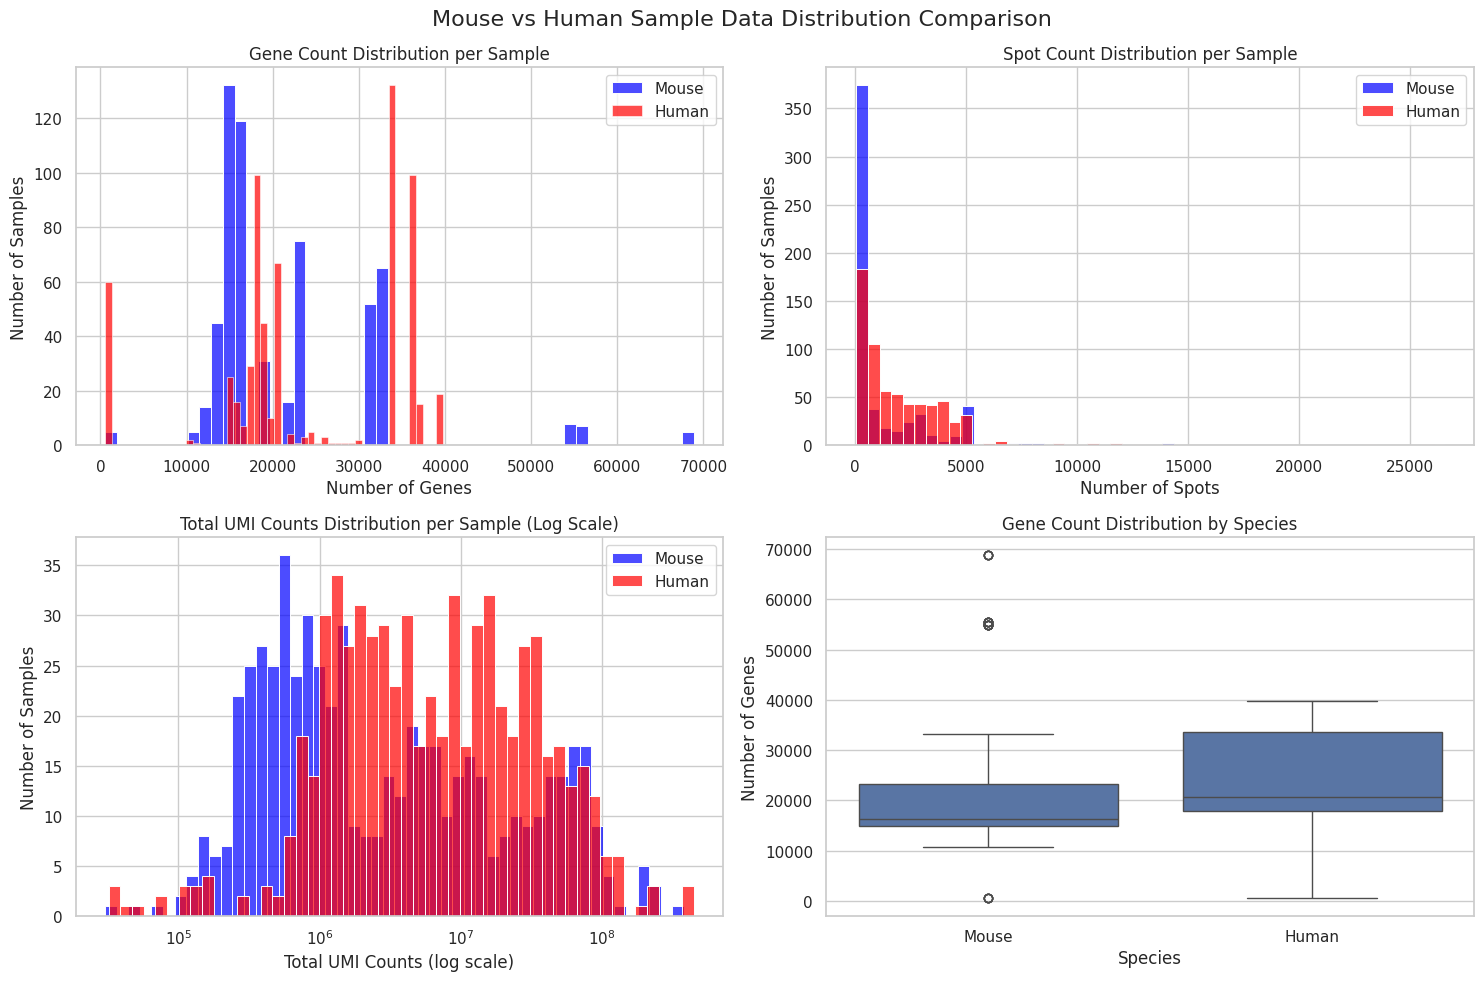


--- Mouse Samples Summary ---
Number of samples: 580
Mean genes per sample: 21275
Mean spots per sample: 1307
Mean total counts per sample: 16410210

--- Human Samples Summary ---
Number of samples: 649
Mean genes per sample: 23845
Mean spots per sample: 2100
Mean total counts per sample: 19707132


In [22]:
# Create separate statistics for mouse and human samples
mouse_stats = []
human_stats = []

# Separate mouse and human sample statistics
for stat in per_sample_stats:
    sample_id = stat['sample_id']
    # Find the corresponding sample object
    sample_obj = next((s for s in all_samples if s.sample_id == sample_id), None)
    if sample_obj:
        # Load metadata to get species information
        try:
            sample_obj.load_st_data(lazy=True)
            species = sample_obj.metadata_dict.get('species', 'Unknown')
            stat_copy = stat.copy()
            stat_copy['species'] = species
            
            if species == 'Mus musculus':
                mouse_stats.append(stat_copy)
            elif species == 'Homo sapiens':
                human_stats.append(stat_copy)
        except:
            continue

# Convert to DataFrames
mouse_df = pd.DataFrame(mouse_stats)
human_df = pd.DataFrame(human_stats)

print(f"Mouse samples: {len(mouse_df)}")
print(f"Human samples: {len(human_df)}")

# Create visualization comparing mouse and human distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Mouse vs Human Sample Data Distribution Comparison', fontsize=16)

# Plot 1: Gene count distribution comparison
sns.histplot(data=mouse_df, x='n_genes', bins=50, alpha=0.7, label='Mouse', color='blue', ax=axes[0,0])
sns.histplot(data=human_df, x='n_genes', bins=50, alpha=0.7, label='Human', color='red', ax=axes[0,0])
axes[0,0].set_title('Gene Count Distribution per Sample')
axes[0,0].set_xlabel('Number of Genes')
axes[0,0].set_ylabel('Number of Samples')
axes[0,0].legend()

# Plot 2: Spot count distribution comparison
sns.histplot(data=mouse_df, x='n_spots', bins=50, alpha=0.7, label='Mouse', color='blue', ax=axes[0,1])
sns.histplot(data=human_df, x='n_spots', bins=50, alpha=0.7, label='Human', color='red', ax=axes[0,1])
axes[0,1].set_title('Spot Count Distribution per Sample')
axes[0,1].set_xlabel('Number of Spots')
axes[0,1].set_ylabel('Number of Samples')
axes[0,1].legend()

# Plot 3: Total counts distribution comparison (log scale)
mouse_total_counts = [float(c) for c in mouse_df['total_counts']]
human_total_counts = [float(c) for c in human_df['total_counts']]

sns.histplot(x=mouse_total_counts, bins=50, alpha=0.7, label='Mouse', color='blue', log_scale=True, ax=axes[1,0])
sns.histplot(x=human_total_counts, bins=50, alpha=0.7, label='Human', color='red', log_scale=True, ax=axes[1,0])
axes[1,0].set_title('Total UMI Counts Distribution per Sample (Log Scale)')
axes[1,0].set_xlabel('Total UMI Counts (log scale)')
axes[1,0].set_ylabel('Number of Samples')
axes[1,0].legend()

# Plot 4: Box plot comparison of key metrics
comparison_data = []
for _, row in mouse_df.iterrows():
    comparison_data.append({'Species': 'Mouse', 'n_genes': row['n_genes'], 'n_spots': row['n_spots'], 'total_counts': float(row['total_counts'])})
for _, row in human_df.iterrows():
    comparison_data.append({'Species': 'Human', 'n_genes': row['n_genes'], 'n_spots': row['n_spots'], 'total_counts': float(row['total_counts'])})

comparison_df = pd.DataFrame(comparison_data)
sns.boxplot(data=comparison_df, x='Species', y='n_genes', ax=axes[1,1])
axes[1,1].set_title('Gene Count Distribution by Species')
axes[1,1].set_ylabel('Number of Genes')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n--- Mouse Samples Summary ---")
print(f"Number of samples: {len(mouse_df)}")
print(f"Mean genes per sample: {mouse_df['n_genes'].mean():.0f}")
print(f"Mean spots per sample: {mouse_df['n_spots'].mean():.0f}")
print(f"Mean total counts per sample: {np.mean(mouse_total_counts):.0f}")

print("\n--- Human Samples Summary ---")
print(f"Number of samples: {len(human_df)}")
print(f"Mean genes per sample: {human_df['n_genes'].mean():.0f}")
print(f"Mean spots per sample: {human_df['n_spots'].mean():.0f}")
print(f"Mean total counts per sample: {np.mean(human_total_counts):.0f}")

# Image QC

ModuleNotFoundError: No module named 'cv2'

# 预处理

In [15]:
# 查询器官为 "Brain" 且疾病状态为 "Healthy" 的样本
brain_samples = dataset.get_samples(
    organ="Brain", 
    oncotree_code=None,  # 根据需要填写
    sample_ids=None,       # 根据需要填写
    species='Mus musculus'          # 根据需要填写
)

print(f"找到 {len(brain_samples)} 个样本。")
print(brain_samples[:3])  # 仅预览前三个

In [214]:
# 查询器官为 "Brain" 且疾病状态为 "Healthy" 的样本
brain_samples = dataset.get_samples(
    organ="Brain", 
    oncotree_code=None,  # 根据需要填写
    sample_ids=None       # 根据需要填写
)

print(f"找到 {len(brain_samples)} 个样本。")
print(brain_samples[:3])  # 仅预览前三个

In [261]:
# 随便选一个样本
sample = brain_samples[0]
print(sample)

In [262]:
sample.load_st_data()
sample.load_wsi()

In [263]:
sample.adata

In [264]:
sample.wsi

In [265]:
sample.spatial_plot_path

In [266]:
# --- (1) 创建综合可视化图 ---
# 默认使用预生成的空间转录组图像，如果没有则实时计算
sample.visualize_comparison(
    color='clusters',
    use_precomputed_spatial_plot=True  # 可以手动切换到 False 以实时计算
)

In [248]:
test_sample = brain_samples[1]
test_sample.load_st_data()
test_sample.load_wsi()
test_sample.visualize_comparison(
    color='clusters',
    use_precomputed_spatial_plot=True  # 可以手动切换到 False 以实时计算
)

In [267]:
dataset.compute_metrics_statistics(samples=brain_samples)

In [269]:
sample.metadata_dict

In [270]:
# --- (1) 创建综合可视化图 ---
# 默认使用预生成的空间转录组图像，如果没有则实时计算
sample.visualize_comparison(
    color='clusters',
    use_precomputed_spatial_plot=True  # 可以手动切换到 False 以实时计算
)

# Open Slide 使用

In [272]:
type(sample.wsi)

In [275]:
# Print basic metadata
slide = sample.wsi

print("Dimensions (level 0):", slide.dimensions)
print("Number of levels:", slide.level_count)
print("Dimensions per level:", slide.level_dimensions)
print("Metadata properties:")
for key, value in slide.properties.items():
    print(f"  {key}: {value}")


In [276]:
from PIL import Image

# Define the region: top-left corner at (x, y), level number, and the size (width, height)
location = (0, 0)  # top-left corner in level 0 coordinates
level = 0          # highest resolution; use a higher level for a lower resolution
size = (512, 512)  # size of the region to extract

# Read the region; the result is a PIL Image
region = slide.read_region(location, level, size)

# Display the region (this will open the image in your default image viewer)
region.show()

In [277]:
region

In [278]:
type(region)

In [282]:
desired_downsample = 16.0  # e.g., you want a quarter of the full resolution
best_level = slide.get_best_level_for_downsample(desired_downsample)
print("Best level for a downsample of 16.0 is:", best_level)

In [283]:
# Choose the desired level (e.g., level 2)
target_level = 3

# Get dimensions for the chosen level
level_dimensions = slide.level_dimensions[target_level]

# Extract the full image at the target level.
# Note: location is (0, 0) in level 0 coordinates and size is in the units of the chosen level.
region = slide.read_region((0, 0), target_level, level_dimensions)

# Convert the image from RGBA to RGB (if transparency is not needed)
region_rgb = region.convert("RGB")

# Display the image using the default image viewer (PIL's show method)
region_rgb.show()

# Always remember to close the slide after you are done
slide.close()

In [284]:
region_rgb

# 尝试切割

In [289]:
sample.adata.obsm['spatial']

In [291]:
sample.adata

In [318]:
sample.adata.obs

In [311]:
type(sample.adata.uns["spatial"])

In [317]:
plt.imshow(sample.adata.uns["spatial"]['ST']['images']['downscaled_fullres'])

In [295]:
import scanpy as sc
adata_test = sample.adata.to_memory().copy()
sc.pl.spatial(adata_test, color='n_counts', spot_size=10)

In [301]:
del adata_test.uns['spatial']

In [302]:
adata_test

In [307]:
sc.pl.spatial(adata_test, color='n_counts', spot_size=200)

# Test for extracting the tiles

In [10]:
import os
import torch
import numpy as np
from PIL import Image, ImageDraw
from tqdm import tqdm
from scipy.sparse import issparse
import concurrent.futures
import matplotlib.pyplot as plt
import random
import logging
import seaborn as sns
from scipy.spatial import cKDTree  # 用于计算最近邻距离

# 配置 logging 模块，输出详细错误信息
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s"
)

def extract_tiles_and_expression(sample, 
                                 tile_size=None, 
                                 tile_size_strategy="median",
                                 tiles_output_dir="output_tiles", 
                                 expr_output_dir="output_expr",
                                 max_workers=32):
    """
    从 HESTSample 对象中提取瓦片和对应的表达量数据，并使用并发线程加速处理。
    
    瓦片大小的自动计算逻辑（基于临近 spot 的距离）：
      - 若 tile_size 为 None，则根据 sample.adata.obs 中每个 spot 的 (pxl_col_in_fullres, pxl_row_in_fullres)
        坐标构建 KD 树，并计算每个点到其最近邻（不包括自身）的欧氏距离。
      - 用户可通过参数 tile_size_strategy 指定采用的统计量：
          * "min"：所有最近邻距离的最小值；
          * "mean"：所有最近邻距离的均值；
          * "median"：所有最近邻距离的中位数（默认）；
          * "max"：所有最近邻距离的最大值。
      - 如果 tile_size 被指定，则直接使用固定值。
    
    瓦片边界处理策略：
      - 对于每个 spot，以其坐标为中心、边长为 tile_size 构造正方形区域。
      - 如果该区域部分在 WSI 范围内，则提取该部分有效区域，并粘贴到完整大小的白色背景上；
      - 如果整个瓦片区域完全不在 WSI 范围内，则认为该点“出界”，不进行处理。
    
    参数:
      sample (HESTSample): 包含空间转录组 AnnData 数据和全分辨率 WSI 的样本实例。
      tile_size (int or None): 瓦片边长（单位像素）。为 None 时自动计算。
      tile_size_strategy (str): 自动计算瓦片大小时采用的策略，可选 "min"、"mean"、"median"、"max"（默认 "median"）。
      tiles_output_dir (str): 保存瓦片图像的目录。
      expr_output_dir (str): 保存表达量数据 (.pt 文件) 的目录。
      max_workers (int): 限制线程池的最大工作线程数，控制并发处理数量，避免内存占用过高。
    
    返回:
      一个列表，每个元素为一个元组：(tile_filename, expr_filename, expr_vector)
      
    函数末尾会随机展示8个在范围内的瓦片及对应 spot 的 top5 基因表达的横向柱状图，
    柱状图使用 seaborn 绘制，其画布与瓦片图像的子图大小一致。
    """
    os.makedirs(tiles_output_dir, exist_ok=True)
    os.makedirs(expr_output_dir, exist_ok=True)
    
    obs_df = sample.adata.obs

    # 1. 检查坐标列是否存在。如果不存在，则使用 adata.obsm['spatial'] 作为坐标来源。
    if 'pxl_col_in_fullres' not in obs_df.columns or 'pxl_row_in_fullres' not in obs_df.columns:
        logging.info("Columns 'pxl_col_in_fullres' and/or 'pxl_row_in_fullres' not found in obs. Using adata.obsm['spatial'] as coordinates.")
        # 假设 adata.obsm['spatial'] 的第一列为 x 坐标，第二列为 y 坐标
        obs_df['pxl_col_in_fullres'] = sample.adata.obsm['spatial'][:, 0]
        obs_df['pxl_row_in_fullres'] = sample.adata.obsm['spatial'][:, 1]

    # 2. 如果 tile_size 为 None，则自动计算
    if tile_size is None:
        points = np.column_stack((obs_df['pxl_col_in_fullres'], obs_df['pxl_row_in_fullres']))
        tree = cKDTree(points)
        dists, _ = tree.query(points, k=2)
        nn_dists = dists[:, 1]  # 排除自身的最近邻距离
        if tile_size_strategy == "min":
            tile_size = int(round(np.min(nn_dists)))
        elif tile_size_strategy == "mean":
            tile_size = int(round(np.mean(nn_dists)))
        elif tile_size_strategy == "max":
            tile_size = int(round(np.max(nn_dists)))
        else:  # 默认 "median"
            tile_size = int(round(np.median(nn_dists)))
        logging.info(f"自动计算瓦片大小：{tile_size} 像素 (策略: {tile_size_strategy})")
    
    X = sample.adata.X
    full_width, full_height = sample.wsi.dimensions

    valid_spots = []
    out_of_bound_spots = []
    for i in range(obs_df.shape[0]):
        spot = obs_df.iloc[i]
        col_coord = int(round(spot['pxl_col_in_fullres']))
        row_coord = int(round(spot['pxl_row_in_fullres']))
        half_tile = tile_size // 2
        top_left_x = col_coord - half_tile
        top_left_y = row_coord - half_tile
        # 判断是否完全出界：右边界 ≤ 0 或 下边界 ≤ 0 或 左边界 ≥ full_width 或 上边界 ≥ full_height
        if (top_left_x + tile_size) <= 0 or (top_left_y + tile_size) <= 0 or \
           top_left_x >= full_width or top_left_y >= full_height:
            out_of_bound_spots.append((i, col_coord, row_coord, top_left_x, top_left_y))
        else:
            valid_spots.append((i, col_coord, row_coord, top_left_x, top_left_y))
    
    logging.info(f"完全出界的点数：{len(out_of_bound_spots)}")
    
    # 随机展示最多 8 个出界的瓦片以供检查
    if out_of_bound_spots:
        sample_indices = random.sample(out_of_bound_spots, min(8, len(out_of_bound_spots)))
        fig, axes = plt.subplots(1, len(sample_indices), figsize=(16, 2))
        if len(sample_indices) == 1:
            axes = [axes]
        for ax, (i, col_coord, row_coord, top_left_x, top_left_y) in zip(axes, sample_indices):
            img = Image.new("RGB", (tile_size, tile_size), (255, 255, 255))
            draw = ImageDraw.Draw(img)
            draw.text((10, tile_size//2 - 10), "Out-of-bound", fill=(255, 0, 0))
            ax.imshow(img)
            ax.axis("off")
            ax.set_title(f"Idx {i}\n({col_coord}, {row_coord})", fontsize=8)
        plt.show()
    
    def process_tile(args):
        i, col_coord, row_coord, top_left_x, top_left_y = args
        # 构造文件名
        tile_filename = os.path.join(tiles_output_dir, f"{sample.sample_id}_{row_coord}_{col_coord}.png")
        expr_filename = os.path.join(expr_output_dir, f"{sample.sample_id}_{row_coord}_{col_coord}.pt")
        
        # 3. 如果文件已存在，则跳过当前 spot 的处理
        if os.path.exists(tile_filename) and os.path.exists(expr_filename):
            logging.info(f"文件已存在，跳过: {tile_filename} 和 {expr_filename}")
            expr_vector = X[i, :]
            if issparse(expr_vector):
                expr_vector = expr_vector.toarray().squeeze()
            else:
                expr_vector = np.array(expr_vector).squeeze()
            return (tile_filename, expr_filename, expr_vector)
        
        left = max(top_left_x, 0)
        top = max(top_left_y, 0)
        right = min(top_left_x + tile_size, full_width)
        bottom = min(top_left_y + tile_size, full_height)
        try:
            region = sample.wsi.read_region((left, top), 0, (right - left, bottom - top))
            region = region.convert("RGB")
        except Exception as e:
            logging.error(
                f"瓦片提取失败，索引 {i}，中心坐标 ({col_coord}, {row_coord})，"
                f"瓦片左上角 ({top_left_x}, {top_left_y})。异常类型：{type(e).__name__}，错误信息：{e}",
                exc_info=True
            )
            return None
        
        tile_img = Image.new("RGB", (tile_size, tile_size), (255, 255, 255))
        offset_x = left - top_left_x
        offset_y = top - top_left_y
        tile_img.paste(region, (offset_x, offset_y))
        
        expr_vector = X[i, :]
        if issparse(expr_vector):
            expr_vector = expr_vector.toarray().squeeze()
        else:
            expr_vector = np.array(expr_vector).squeeze()
        expr_tensor = torch.tensor(expr_vector, dtype=torch.float32)
        expr_sparse = expr_tensor.to_sparse()
        
        try:
            tile_img.save(tile_filename)
        except Exception as e:
            logging.error(
                f"保存瓦片图像失败，索引 {i}，文件名：{tile_filename}。异常：{e}",
                exc_info=True
            )
            return None
        try:
            torch.save(expr_sparse, expr_filename)
        except Exception as e:
            logging.error(
                f"保存表达数据失败，索引 {i}，文件名：{expr_filename}。异常：{e}",
                exc_info=True
            )
            return None
        
        return (tile_filename, expr_filename, expr_vector)
    
    results = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_tile, args) for args in valid_spots]
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="处理有效瓦片"):
            result = future.result()
            if result is not None:
                results.append(result)
    
    # 随机展示8个在范围内的瓦片及其 top5 基因表达柱状图（上下两行）
    if results:
        sample_results = random.sample(results, min(8, len(results)))
        n = len(sample_results)
        fig, axes = plt.subplots(2, n, figsize=(n * 3, 2 * 3))
        if n == 1:
            axes = np.array([[axes[0]], [axes[1]]])
        for j, (tile_filename, expr_filename, expr_vector) in enumerate(sample_results):
            # 上行：展示瓦片图像
            try:
                img = Image.open(tile_filename)
                axes[0, j].imshow(img)
                axes[0, j].axis("off")
                title = os.path.basename(tile_filename).replace(".png", "")
                axes[0, j].set_title(title, fontsize=8)
            except Exception as e:
                logging.error(f"展示瓦片失败: {tile_filename}，异常: {e}", exc_info=True)
                axes[0, j].axis("off")
            
            # 下行：展示 top5 基因表达的横向柱状图，使用 seaborn 绘制
            try:
                expr_arr = np.array(expr_vector)
                top5_idx = np.argsort(expr_arr)[-3:][::-1]
                top5_values = expr_arr[top5_idx]
                gene_names = np.array(sample.adata.var_names)[top5_idx]
                sns.barplot(x=top5_values, y=gene_names, ax=axes[1, j], palette="Set2", hue=gene_names)
                axes[1, j].set_xlabel("")
                axes[1, j].set_ylabel("")
                axes[1, j].tick_params(axis='y', labelsize=6)
                axes[1, j].tick_params(axis='x', labelsize=6)
            except Exception as e:
                logging.error(f"展示柱状图失败: {expr_filename}，异常: {e}", exc_info=True)
                axes[1, j].axis("off")
        plt.tight_layout()
        plt.show()
    
    return results

In [11]:
import os
os.chdir("/home1/jijh/diffusion_project/ADiffusion")
from src.pipeline.hest_loading import HESTDataset

In [4]:
data_dir = "/cwStorage/nodecw_group/jijh/hest_1k"
dataset = HESTDataset(data_dir=data_dir)

# 查询器官为 "Brain" 
brain_samples = dataset.get_samples(
    organ="Brain", 
    oncotree_code=None,  # 根据需要填写
    sample_ids=None,       # 根据需要填写
    species='Mus musculus'          # 根据需要填写
)


print(f"找到 {len(brain_samples)} 个样本。")
print(brain_samples[:3])  # 仅预览前三个

In [5]:
# 随便选一个样本
sample = brain_samples[2]
print(sample)
sample.load_st_data()
sample.load_wsi()

In [33]:
sample.wsi.dimensions

In [34]:
sample.adata.obs

In [6]:
# --- (1) 创建综合可视化图 ---
# 默认使用预生成的空间转录组图像，如果没有则实时计算
sample.visualize_comparison(
    color='clusters',
    use_precomputed_spatial_plot=True  # 可以手动切换到 False 以实时计算
)

In [7]:
tiles_output_dir = '/cwStorage/nodecw_group/jijh/hest_output/output_tiles'
expr_output_dir = '/cwStorage/nodecw_group/jijh/hest_output/output_expr'

extract_tiles_and_expression(sample, tile_size=None, tiles_output_dir=tiles_output_dir, expr_output_dir=expr_output_dir)

In [25]:
tiles_output_dir = '/cwStorage/nodecw_group/jijh/hest_output/output_tiles'
expr_output_dir = '/cwStorage/nodecw_group/jijh/hest_output/output_expr'

extract_tiles_and_expression(sample, tile_size=None, tiles_output_dir=tiles_output_dir, expr_output_dir=expr_output_dir)

In [9]:
save_dir = '/cwStorage/nodecw_group/jijh/hest_output'
all_results = {}
for sample in tqdm(brain_samples, desc="处理 Brain 样本"):
    logging.info(f"开始处理样本 {sample.sample_id} ...")
    sample.load_st_data()
    sample.load_wsi()
    # 为每个样本建立独立的输出文件夹，避免文件混淆
    sample_tiles_dir = os.path.join(save_dir, f"{sample.sample_id}_tiles")
    sample_expr_dir = os.path.join(save_dir, f"{sample.sample_id}_expr")
    
    results = extract_tiles_and_expression(
        sample, 
        tile_size=None, 
        tile_size_strategy="median",
        tiles_output_dir=sample_tiles_dir, 
        expr_output_dir=sample_expr_dir,
        max_workers=32
    )
    all_results[sample.sample_id] = results
    logging.info(f"样本 {sample.sample_id} 处理完成，共处理瓦片数量：{len(results)}")

In [11]:
sample.adata.obs

In [15]:
sample.visualize_comparison(
    color='clusters',
    use_precomputed_spatial_plot=True  # 可以手动切换到 False 以实时计算
)

In [16]:
brain_samples

In [18]:
test_sample = brain_samples[-1]

In [19]:
test_sample.load_st_data()
test_sample.load_wsi()


In [ ]:
test_sample.adata.obs

In [23]:
test_sample.adata.obsm['spatial']

In [21]:
test_sample.visualize_comparison(
    color='clusters',
    use_precomputed_spatial_plot=True  # 可以手动切换到 False 以实时计算
)

In [ ]:
data_dir = "/cwStorage/nodecw_group/jijh/hest_1k"
dataset = HESTDataset(data_dir=data_dir)

# 查询器官为 "Brain" 
brain_samples = dataset.get_samples(
    organ="Brain", 
    oncotree_code=None,  # 根据需要填写
    sample_ids=None,       # 根据需要填写
    species='Mus musculus'          # 根据需要填写
)


print(f"找到 {len(brain_samples)} 个样本。")
print(brain_samples[:3])  # 仅预览前三个

In [26]:
save_dir = '/cwStorage/nodecw_group/jijh/hest_output'
all_results = {}
for sample in tqdm(brain_samples, desc="处理 Brain 样本"):
    logging.info(f"开始处理样本 {sample.sample_id} ...")
    sample.load_st_data()
    sample.load_wsi()
    # 为每个样本建立独立的输出文件夹，避免文件混淆
    sample_tiles_dir = os.path.join(save_dir, f"{sample.sample_id}_tiles")
    sample_expr_dir = os.path.join(save_dir, f"{sample.sample_id}_expr")
    
    results = extract_tiles_and_expression(
        sample, 
        tile_size=None, 
        tile_size_strategy="median",
        tiles_output_dir=sample_tiles_dir, 
        expr_output_dir=sample_expr_dir,
        max_workers=32
    )
    all_results[sample.sample_id] = results
    logging.info(f"样本 {sample.sample_id} 处理完成，共处理瓦片数量：{len(results)}")

# Process all the samples

In [ ]:
data_dir = "/cwStorage/nodecw_group/jijh/hest_1k"
dataset = HESTDataset(data_dir=data_dir)


all_samples = dataset.get_samples(
    organ=None, 
    oncotree_code=None,  # 根据需要填写
    sample_ids=None,       # 根据需要填写
    species=None        # 根据需要填写
)




In [14]:
print(f"找到 {len(all_samples)} 个样本。")
print(all_samples[:3])  # 仅预览前三个

In [16]:
all_samples

In [15]:
save_dir = '/cwStorage/nodecw_group/jijh/hest_output'
all_results = {}

# Create a list to track failed samples
failed_samples = []

# Use all_samples instead of brain_samples
for sample in tqdm(all_samples, desc="处理所有样本"):
    try:
        # 为每个样本建立独立的输出文件夹
        sample_tiles_dir = os.path.join(save_dir, f"{sample.sample_id}_tiles")
        sample_expr_dir = os.path.join(save_dir, f"{sample.sample_id}_expr")
        
        # Check if the directories already contain processed files
        if os.path.exists(sample_tiles_dir) and os.path.exists(sample_expr_dir):
            # Check if any files exist in these directories
            if len(os.listdir(sample_tiles_dir)) > 0 and len(os.listdir(sample_expr_dir)) > 0:
                logging.info(f"样本 {sample.sample_id} 已经处理过，跳过")
                continue
        
        logging.info(f"开始处理样本 {sample.sample_id} ...")
        sample.load_st_data()
        sample.load_wsi()
        
        results = extract_tiles_and_expression(
            sample, 
            tile_size=None, 
            tile_size_strategy="median",
            tiles_output_dir=sample_tiles_dir, 
            expr_output_dir=sample_expr_dir,
            max_workers=32
        )
        
        all_results[sample.sample_id] = results
        logging.info(f"样本 {sample.sample_id} 处理完成，共处理瓦片数量：{len(results)}")
        
    except Exception as e:
        logging.error(f"处理样本 {sample.sample_id} 时出错: {str(e)}", exc_info=True)
        failed_samples.append((sample.sample_id, str(e)))

# 打印失败的样本列表
if failed_samples:
    logging.warning(f"处理失败的样本数量: {len(failed_samples)}")
    for sample_id, error in failed_samples:
        logging.warning(f"  - {sample_id}: {error}")
else:
    logging.info("所有样本处理成功！")